# Finite Size Scaling (2D Ising model)

## Useful functions

$$m(T,L) = L^{-\beta/\nu} \hat f[(T - T_c)L^{1/\nu}] $$
$$\chi(T,L) = L^{\gamma/\nu}\hat g[(T-T_c)L^{1/\nu}]$$
<br>
Exact values for 2D Ising model are $\beta = \frac{1}{8}$, $\nu = 1$, and $\gamma = \frac{7}{4}$. <br><br>

We choose $x$ axis as $x = (T-T_c)L^{1/\nu}$ and $y$ axis as $y = m(T,L)L^{\beta/\nu}$. <br>
Therefore, $x = (T - 2.269)L$ and $y = m(T,L)L^{1/8}$. <br><br>

We choose $x'$ aixs as $x' = (T-T_c)L^{1/\nu}$ and $y'$ axis as $y' = \chi(T,L)L^{-\gamma/\nu}$. <br>
Therefore, $x' = (T-2.269)L$ and $y' = \chi(T,L)L^{-7/4}$.


In [8]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm, tnrange
import warnings
warnings.filterwarnings("ignore")
import random
import pickle as pkl
import pandas as pd
from scipy.stats import entropy
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base='drive/MyDrive'
except:
    if torch.cuda.device_count()>1:
        base='.'
    else:
        base='Google Drive'

if CUDA:
    device='cuda'
else:
    device='cpu'
torch.cuda.is_available()

Mounted at /content/drive


False

In [2]:

def magnetization(lattice):
    '''
    This is a function that returns absolute of spontaneous magnetization of a spin configuration.
    Not returns magnetization per spin.
    '''
    L = len(lattice)
    m = 0
    for i in range(L):
        for j in range(L):
            m += lattice[i,j]
    
    return abs(m)

In [3]:
def Ising_model(lattice, temperature_array, n0, d_delta, mcmax):
    '''
    This if a function which conducts computing statistics of 2D Ising lattice. 
    This function returns (ensemble) averaged magnetization per spin, magnetic susceptibility, and 4th cummulant (the Binder cummulant).
    '''
    
    L = len(lattice)
    
    M_average = []
    suscept = []
    cummulant = []
    
    for tt in temperature_array:
        m = 0
        mag = []
        mag2 = []
        mag4 = []
        equil = 0
        count = 0
        
        while equil <= mcmax:
            if equil < n0:
                for i in range(L):
                    for j in range(L):
                        s = lattice[i,j]
                        neigh = lattice[(i+1)%L, j] + lattice[i,(j+1)%L] + lattice[(i-1)%L,j] + lattice[i,(j-1)%L]
                        DE = 2 * s * neigh 
 
                        if DE < 0:
                            s *= -1 
                        elif np.random.rand() < np.exp(- DE*1/tt):
                            s *= -1 
                        lattice[i,j] = s
                equil += 1;
                
            else:
                x = np.random.randint(L)
                y = np.random.randint(L)
                s = lattice[x,y]  
                neigh = lattice[(x+1)%L, y] + lattice[x,(y+1)%L] + lattice[(x-1)%L,y] + lattice[x,(y-1)%L]
                DE = 2 * s * neigh 

                #accept or reject 
                if DE < 0:
                    s *= -1 

                elif np.random.rand() < np.exp(- DE*1/tt):
                    s *= -1 

                lattice[x,y] = s
                count += 1;
                m = 0;

                if count == n_delta:
                    count = 0;
                    m = magnetization(lattice)
                    mag.append(m)
                    mag2.append(m**2) 
                    mag4.append(m**4)

                equil += 1;
            
        M_average.append(np.average(mag)/L**2)
        suscept.append((np.average(mag2) - (np.average(mag))**2)/L**2)
        cummulant.append(1- 1/3 * np.average(mag4)/(np.average(mag2)**2)) 
        
    return M_average, suscept, cummulant

In [4]:
def finite_size_scaling(lattice, temperature_array, critical_temperature, mags, suscepts):
    '''
    This function is a function for finite size scaling.
    '''
    
    L = len(lattice)
    scaled_temperature = (temperature_array - critical_temperature) * L
    Mags, Sus = [], []
    
    for m in mags:
        Mags.append(m * L**(+1/8))
    for s in suscepts:
        Sus.append(s * L **(-7/4))
        
    return scaled_temperature, Mags, Sus 

### Critical point finding

In [5]:
L1 = 3

lattice1 = - np.ones((L1,L1))


T = np.linspace(1,20,100)


n0 = 2000
n_delta = n0/2
mcmax = 1500000

In [6]:
start = time.time()
mav1, sus1, u1 = Ising_model(lattice1, T, n0, n_delta, mcmax)

end = time.time() - start
print(end/60, 'min')

35.93952214717865 min


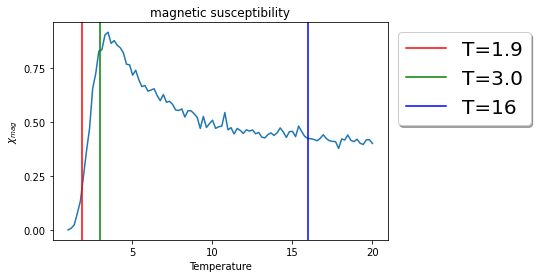

In [7]:
#plot of magnetizations
plt.plot(T, sus1, label = None)
plt.axvline(x=1.9, c='r', label='T=1.9')
plt.axvline(x=3.0, c='g', label='T=3.0')
plt.axvline(x=16, c='b', label='T=16')
# plt.xticks([1.9,3.0,16],[1.9,3.0,16])


plt.title('magnetic susceptibility');
plt.xlabel('Temperature');
plt.ylabel('$\chi_{mag}$');
plt.legend(loc = 'upper right');
plt.rcParams["font.size"] = "20"
plt.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)

# plt.savefig('susceptibilities.png')

In [9]:
def decimal_to_binary(integer, n_hid):
    string=bin(int(integer))[2:]
    list0=[float(d) for d in string]
    while len(list0)<n_hid:
        list0=[0.]+list0
    return torch.tensor([list0])

def Ising_energy(v_list):
    L = 3
    E_list=[]
    for n in range(len(v_list)):
        v=v_list[n]
        E = 0
        for i in range(L):
            for j in range(L):
                s = v[i,j]
                neigh = v[(i+1)%L, j] + v[i,(j+1)%L] + v[(i-1)%L,j] + v[i,(j-1)%L] 
                E += -neigh * s
        E_list.append(E/2)
    return np.array(E_list)

In [16]:
n_vis=9
T=1.9
T_list=[1.9, 3.0, 16]

v_list_ising=[]
v_list_ising2=[]
for s in range(2**n_vis):
    v=decimal_to_binary(s, n_vis)[0]
    v_list_ising.append(np.reshape(v,(3,3))*2-1)
    v_list_ising2.append(v)
v_list_ising2=torch.stack(v_list_ising2).to(device)      
for T in T_list:
    bf_list=np.exp(-Ising_energy(v_list_ising)/T)
    Pv=np.array(torch.tensor(bf_list/sum(bf_list)))

    trainset=np.array(pd.read_pickle('{base}/loss_IG/3*3/3*3_full_T={T}.pkl'.format(base=base, T=T)))

    mean_train_list=[]
    mean_true=0
    for m in range(10):
        mean_train_list.append(np.mean(Ising_energy(np.reshape((trainset[m])*2-1,(len(trainset[0]),3,3)))))
    mean_true=np.dot(Ising_energy(v_list_ising), np.array(Pv))
    print('T={T}, True E={truemean}, sampled E_mean={mean}, sampled E_std={std}'.format(T=T, truemean=mean_true, mean=np.mean(mean_train_list), std=np.std(mean_train_list)))


T=1.9, True E=-16.35085105895996, sampled E_mean=-16.356281250000002, sampled E_std=0.018923713525462335
T=3.0, True E=-10.393972396850586, sampled E_mean=-10.3849140625, sampled E_std=0.033653969463416054
T=16, True E=-1.2051705121994019, sampled E_mean=-1.2084140625, sampled E_std=0.020010405313255916
